In [1]:
!pip install simpy

In [2]:
import numpy as np
import scipy
import plotly as ply
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import simpy
import random
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')
titanic = pd.read_csv("/content/drive/My Drive/Systems Engineering/titanic.csv")

Mounted at /content/drive


# Constructing survival probabilities
## Must test with dataset given and then extrapolate to larger populations.

In [33]:
np.random.seed(10)

def Normaldist(mu, sigma, min_size, max_size):
  return int(np.clip(np.random.normal(mu, sigma, 1), min_size, max_size))


def Psurvivability(df, category, testsize):
  # Following strategy outlined in
  # https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

  # factors we have explored in last assignment
  gender = df["Sex"].map({"male": 0, "female": 1})
  age = df['Age'].fillna(df["Age"].median())

  if category == 'Passenger':
    fare = df['Fare'].fillna(df["Fare"].median())
    pclass = df['Pclass'].fillna(df["Pclass"].median())
    X = pd.concat([gender, age, fare, pclass], axis=1)
  else:
    # pclass = df['Class'].fillna(df["Class"].median())
    X = pd.concat([gender, age], axis=1)
    # print(X)

  # Splitting data into training and testing subsets
  # X = pd.concat([gender, age, fare, pclass], axis=1)
  y = df['Survived']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=0)

  # Running a model that uses logistic regression to calculate survival probability
  # for each person
  model = Pipeline([("scale", StandardScaler()),
   ("logreg", LogisticRegression(max_iter=1000))])

  # print('Score:', model.fit(X_train, y_train).score(X_test, y_test))
  model.fit(X_train, y_train)


  return model, model.predict_proba(X)[:, 1]


## Getting survival probabilities for the passengers
Pfilename = "/content/drive/My Drive/Systems Engineering/titanic.csv"
Cfilename = "/content/drive/My Drive/Systems Engineering/titanic-tot.csv"

Pdf = pd.read_csv(Pfilename)
titanic["p_survive"] = Psurvivability(Pdf, 'Passenger', testsize = 0.25)[1]


## Getting survival probabilities for the crew

Cdf = pd.read_csv(Cfilename)

Cdf = Cdf[ ~Cdf['class'].str.contains(r'[123]', na=False)]

Cdf.rename(columns={'gender': 'Sex', 'age':'Age', 'survived':'Survived'}, inplace=True)
Cdf['Survived'] = Cdf["Survived"].map({"no": 0, "yes": 1})

Cdf["p_survive"] = Psurvivability(Cdf, 'Crew', testsize = 0.25)[1]

# print(titanic['p_survive'].mean())

# Testing predictions

## By ticket price

In [77]:
# Create histogram of ages
binlist = []
for i in range(0, int(max(titanic['Fare'])), 10):
  binlist.append(i)
titanic["TicketPrice"] = pd.cut(titanic["Fare"], bins= binlist)

# Compare survival by bin
grouped = round(titanic.groupby("TicketPrice")["Survived"].agg(["mean", "count"]),2)
pgrouped= round(titanic.groupby("TicketPrice")["p_survive"].agg(["mean"]),2)

perror = np.zeros(len(grouped))
for i in range(len(grouped)):
  perror[i] = round((grouped.iloc[i,0] - pgrouped.iloc[i,0])/(grouped.iloc[i,0])*100,2)

grouped.rename(columns={"mean": "Average Survival Rate"}, inplace=True)
grouped['Predicted Survival Rate'] = pgrouped['mean']
grouped['Percent Error'] = perror
grouped  = grouped[grouped['Average Survival Rate'].notna()]
# print(grouped)

# Bias (signed): Mean Percentage Error
mpe = np.average(grouped['Percent Error'], weights=grouped['count'])

# Accuracy (unsigned): Mean Absolute Percentage Error
mape = np.average(np.abs(grouped['Percent Error']), weights=grouped['count'])

print(f"Weighted Mean Percentage Error   : {mpe:.4f} %")
print(f"Weighted Mean ABS Percentage Error: {mape:.4f} %")

Weighted Mean Percentage Error   : -1.2336 %
Weighted Mean ABS Percentage Error: 8.8640 %


## By Ticket Class

In [78]:
pclass = titanic['Pclass']
S_cond = titanic['Survived'] == 1
D_cond = titanic['Survived'] == 0

grouped = round(titanic.groupby("Pclass")["Survived"].agg(["mean", "count"]),2)
pgrouped= round(titanic.groupby("Pclass")["p_survive"].agg(["mean"]),2)

perror = np.zeros(len(grouped))
for i in range(len(grouped)):
  perror[i] = round((grouped.iloc[i,0] - pgrouped.iloc[i,0])/(grouped.iloc[i,0])*100,2)

grouped.rename(columns={"mean": "Average Survival Rate"}, inplace=True)
grouped['Predicted Survival Rate'] = pgrouped['mean']
grouped['Percent Error'] = perror
grouped  = grouped[grouped['Average Survival Rate'].notna()]
print(grouped)

# Bias (signed): Mean Percentage Error
mpe = np.average(grouped['Percent Error'], weights=grouped['count'])

# Accuracy (unsigned): Mean Absolute Percentage Error
mape = np.average(np.abs(grouped['Percent Error']), weights=grouped['count'])

print(f"Weighted Mean Percentage Error   : {mpe:.4f} %")
print(f"Weighted Mean ABS Percentage Error: {mape:.4f} %")


        Average Survival Rate  count  Predicted Survival Rate  Percent Error
Pclass                                                                      
1                        0.63    216                     0.62           1.59
2                        0.47    184                     0.47           0.00
3                        0.24    491                     0.26          -8.33
Weighted Mean Percentage Error   : -4.2049 %
Weighted Mean ABS Percentage Error: 4.9758 %


## By Gender

In [36]:
# By Gender - passengers
gender = titanic['Sex'].map({"male": 0, "female": 1})
S_cond = titanic['Survived'] == 1
D_cond = titanic['Survived'] == 0
Mcond = gender == 0
Fcond = gender == 1

surv = titanic['Survived']

pMcond = titanic['Sex'] == 'male'
pFcond = titanic['Sex'] == 'female'

predsurv = titanic['p_survive']

print('Average survival for women:', round(surv[Fcond].mean(),4))
print('Average survival for men:', round(surv[Mcond].mean(),4))
print('Predicted survival for women:', round(predsurv[pFcond].mean(),4),
      'Percent Difference:', round((surv[Fcond].mean() - predsurv[pFcond].mean())/(surv[Fcond].mean())*100,4),'%')
print('Predicted survival for men:', round(predsurv[pMcond].mean(),4),
      'Percent Difference:', round((surv[Mcond].mean() - predsurv[pMcond].mean())/(surv[Mcond].mean())*100,4),'%')

# By Gender - crew
gender = Cdf['Sex'].map({"male": 0, "female": 1})
S_cond = Cdf['Survived'] == 1
D_cond = Cdf['Survived'] == 0

Mcond = gender == 0
Fcond = gender == 1

pMcond = Cdf['Sex'] == 'male'
pFcond = Cdf['Sex'] == 'female'

surv = Cdf['Survived']

predsurv = Cdf['p_survive']

print('Average survival for female crew:', round(surv[Fcond].mean(),4))
print('Average survival for male crew:', round(surv[Mcond].mean(),4))
print('Predicted survival for female crew:', round(predsurv[pFcond].mean(),4),
      'Percent Difference:', round((surv[Fcond].mean() - predsurv[pFcond].mean())/(surv[Fcond].mean())*100,4),'%')
print('Predicted survival for male crew:', round(predsurv[pMcond].mean(),4),
      'Percent Difference:', round((surv[Mcond].mean() - predsurv[pMcond].mean())/(surv[Mcond].mean())*100,4),'%')


Average survival for women: 0.742
Average survival for men: 0.1889
Predicted survival for women: 0.7471 Percent Difference: -0.6821 %
Predicted survival for men: 0.1941 Percent Difference: -2.7301 %
Average survival for female crew: 0.8696
Average survival for male crew: 0.2203
Predicted survival for female crew: 0.7931 Percent Difference: 8.7932 %
Predicted survival for male crew: 0.2288 Percent Difference: -3.8502 %


## By Age

In [84]:
# Create histogram of ages

## For passengers

titanic["AgeGroup"] = pd.cut(titanic["Age"], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80])

# Compare survival by bin
grouped = round(titanic.groupby("AgeGroup")["Survived"].agg(["mean", "count"]),2)
pgrouped= round(titanic.groupby("AgeGroup")["p_survive"].agg(["mean"]),2)

perror = np.zeros(len(grouped))
for i in range(len(grouped)):
  perror[i] = round((grouped.iloc[i,0] - pgrouped.iloc[i,0])/(grouped.iloc[i,0])*100,2)

grouped.rename(columns={"mean": "Average Survival Rate"}, inplace=True)
grouped['Predicted Survival Rate'] = pgrouped['mean']
grouped['Percent Error'] = perror

# Bias (signed): Mean Percentage Error
mpe = np.average(grouped['Percent Error'], weights=grouped['count'])

# Accuracy (unsigned): Mean Absolute Percentage Error
mape = np.average(np.abs(grouped['Percent Error']), weights=grouped['count'])

print(f"Weighted Mean Percentage Error   : {mpe:.4f} %")
print(f"Weighted Mean ABS Percentage Error: {mape:.4f} %")

## For crew

Cdf["AgeGroup"] = pd.cut(Cdf["Age"], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80])

# Compare survival by bin
grouped = round(Cdf.groupby("AgeGroup")["Survived"].agg(["mean", "count"]),2)
pgrouped= round(Cdf.groupby("AgeGroup")["p_survive"].agg(["mean"]),2)

perror = np.zeros(len(grouped))
for i in range(len(grouped)):
  perror[i] = round((grouped.iloc[i,0] - pgrouped.iloc[i,0])/(grouped.iloc[i,0])*100,2)

grouped.rename(columns={"mean": "Average Survival Rate"}, inplace=True)
grouped['Predicted Survival Rate'] = pgrouped['mean']
grouped['Percent Error'] = perror
grouped = grouped[grouped['Average Survival Rate'].notna()]
print(grouped)

# Bias: Mean Percentage Error
mpe = np.average(grouped['Percent Error'], weights=grouped['count'])

# Mean Absolute Percentage Error
mape = np.average(np.abs(grouped['Percent Error']), weights=grouped['count'])

print(f"Weighted Mean Percentage Error   : {mpe:.4f} %")
print(f"Weighted Mean ABS Percentage Error: {mape:.4f} %")

Weighted Mean Percentage Error   : -0.2110 %
Weighted Mean ABS Percentage Error: 7.7122 %
          Average Survival Rate  count  Predicted Survival Rate  Percent Error
AgeGroup                                                                      
(10, 20]                   0.17     84                     0.26         -52.94
(20, 30]                   0.27    359                     0.25           7.41
(30, 40]                   0.22    307                     0.24          -9.09
(40, 50]                   0.23    113                     0.24          -4.35
(50, 60]                   0.21     24                     0.19           9.52
(60, 70]                   0.33      3                     0.17          48.48
Weighted Mean Percentage Error   : -5.2753 %
Weighted Mean ABS Percentage Error: 12.0935 %


0      20–40
1      20–40
2      20–40
3      20–40
4      20–40
       ...  
886    20–40
887    10–20
888      NaN
889    20–40
890    20–40
Name: Age, Length: 891, dtype: category
Categories (5, object): ['0–10' < '10–20' < '20–40' < '40–60' < '60–80']
Average age of survivors: 28.34 years
Average age of non-survivors: 30.63 years


Text(30, 70, 'Bin size = 5 years')

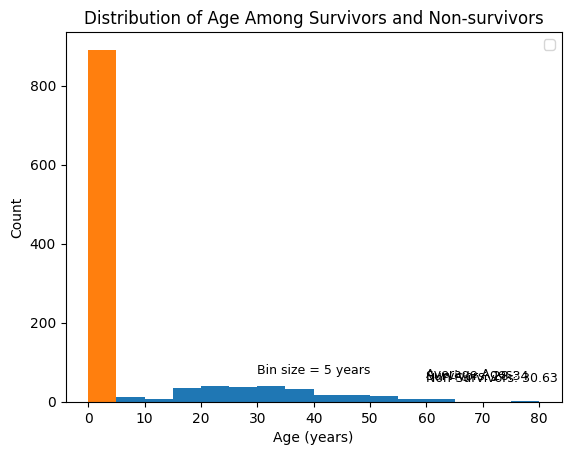

In [9]:


# Create histogram of ages
agebins = pd.cut(titanic["Age"], bins=[0, 10, 20, 40, 60, 80], labels=["0–10", "10–20", "20–40", "40–60", "60–80"])
print(agebins)

# Making conditions for survived/non-survived
S_cond = titanic['Survived'] == 1
D_cond = titanic['Survived'] == 0

survivors = titanic[S_cond]['Age']
deaths = titanic[D_cond]['Age']

avgsurv = survivors.mean()
avgdeath = deaths.mean()

# Predicted values
predsurv = titanic['p_survive']


# Average age of survivors
print('Average age of survivors:', round(np.average(survivors[survivors.notna()]),2), 'years')

# Average age of non-survivors
print('Average age of non-survivors:', round(np.average(deaths[deaths.notna()]),2), 'years')


                  # Make histograms of survivor ages and non-survivor ages
bins = 16
hrange = (0,80)
density= False
plt.hist(survivors[survivors.notna()], bins = bins, range = hrange, density = density);
plt.hist(predsurv, bins = bins, range = hrange, density = density);
plt.legend(loc = 'best')
plt.xlabel('Age (years)')
plt.ylabel('Count')
plt.title('Distribution of Age Among Survivors and Non-survivors')
x = 60
plt.annotate('Average Ages:', fontsize = 9, xy = [x,60])
plt.annotate(f'Survivors: {round(np.average(survivors[survivors.notna()]),2)}', fontsize = 9, xy = [x,55])
plt.annotate(f'Non-Survivors: {round(np.average(deaths[deaths.notna()]),2)}', fontsize = 9, xy = [x,50])
plt.annotate(f'Bin size = {int(80/bins)} years', fontsize = 9, xy = [30,70])

## By Cabin

In [10]:
# By cabin

S_cond = titanic['Survived'] == 1
D_cond = titanic['Survived'] == 0
cabins = titanic['Cabin']
fare = titanic['Fare']
fare = fare[fare.notna()]

surv = cabins[S_cond]; nonsurv = cabins[D_cond]
letters = ['A', 'B', 'C', 'D', 'E', 'T']

cabin_prefix = cabins.str[0]
# fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6), sharey=True)
sdata = []; ddata = []
ratios = []; avgtick = []
totalincabins = []; medtick = []
avgsurv = []; predsurv = []; gap = []

for letter in letters:
    mask = cabin_prefix == letter
    ratios.append(len(surv[mask]) / len(cabins[mask]))
    avgtick.append(np.average(titanic[titanic['Cabin'].notna()][titanic['Fare'].notna()]['Fare'][mask]))
    totalincabins.append(len(cabins[mask]))
    medtick.append(np.median(titanic[titanic['Cabin'].notna()][titanic['Fare'].notna()]['Fare'][mask]))

    avgsurv.append(titanic['Survived'][mask].mean())
    predsurv.append(titanic['p_survive'][mask].mean())
    gap.append((titanic['Survived'][mask].mean() - titanic['p_survive'][mask].mean())/(titanic['Survived'][mask].mean())*100)

    sdata.append(len(surv[mask]))
    ddata.append(len(nonsurv[mask]))

print('Average survival rates per cabin prefix:', avgsurv)
print('Predicted survival rates per cabin prefix:', predsurv)
print('Gap:', gap)

Average survival rates per cabin prefix: [np.float64(0.4666666666666667), np.float64(0.7446808510638298), np.float64(0.5932203389830508), np.float64(0.7575757575757576), np.float64(0.75), np.float64(0.0)]
Predicted survival rates per cabin prefix: [np.float64(0.4197286363858187), np.float64(0.6952998350696339), np.float64(0.643643629423299), np.float64(0.6484461289359884), np.float64(0.5735342214675041), np.float64(0.34750567749705014)]
Gap: [np.float64(10.058149345895995), np.float64(6.631165004934873), np.float64(-8.499926102784695), np.float64(14.405110980449528), np.float64(23.52877047099945), np.float64(-inf)]


In [ ]:



def survivor(env, prob):
  record = []
  survived = np.random.random() < prob
  record.append(survived)
  return record




In [ ]:
"""
Bank renege example

Covers:

- Resources: Resource
- Condition events

Scenario:
  A counter with a random service time and customers who renege. Based on the
  program bank08.py from TheBank tutorial of SimPy 2. (KGM)

"""

import random

import simpy

RANDOM_SEED = 42
NEW_CUSTOMERS = 5  # Total number of customers
INTERVAL_CUSTOMERS = 10  # Generate new customers roughly every x seconds
MIN_PATIENCE = 1  # Min. customer patience
MAX_PATIENCE = 3  # Max. customer patience


def source(env, number, interval, counter):
    """Source generates customers randomly"""
    for i in range(number):
        c = customer(env, f'Customer{i:02d}', counter, time_in_bank=12.0)
        env.process(c)
        t = random.expovariate(1.0 / interval)
        yield env.timeout(t)


def customer(env, name, counter, time_in_bank):
    """Customer arrives, is served and leaves."""
    arrive = env.now
    print(f'{arrive:7.4f} {name}: Here I am')

    with counter.request() as req:
        patience = random.uniform(MIN_PATIENCE, MAX_PATIENCE)
        # Wait for the counter or abort at the end of our tether
        results = yield req | env.timeout(patience)

        wait = env.now - arrive

        if req in results:
            # We got to the counter
            print(f'{env.now:7.4f} {name}: Waited {wait:6.3f}')

            tib = random.expovariate(1.0 / time_in_bank)
            yield env.timeout(tib)
            print(f'{env.now:7.4f} {name}: Finished')

        else:
            # We reneged
            print(f'{env.now:7.4f} {name}: RENEGED after {wait:6.3f}')


# Setup and start the simulation
print('Bank renege')
random.seed(RANDOM_SEED)
env = simpy.Environment()

# Start processes and run
counter = simpy.Resource(env, capacity=1)
env.process(source(env, NEW_CUSTOMERS, INTERVAL_CUSTOMERS, counter))
env.run()

Bank renege
 0.0000 Customer00: Here I am
 0.0000 Customer00: Waited  0.000
 3.8595 Customer00: Finished
10.2006 Customer01: Here I am
10.2006 Customer01: Waited  0.000
12.7265 Customer02: Here I am
13.9003 Customer02: RENEGED after  1.174
23.7507 Customer01: Finished
34.9993 Customer03: Here I am
34.9993 Customer03: Waited  0.000
37.9599 Customer03: Finished
40.4798 Customer04: Here I am
40.4798 Customer04: Waited  0.000
43.1401 Customer04: Finished


# Now Extrapolating to more people

In [87]:
# Distributions
from scipy.optimize import curve_fit
from scipy.stats import binom
from scipy.stats import t

def distr(x,y, func, p0, output):
  '''
  Function that uses scipy opt curve fit
  to fit a function to the data.
  '''

  popt, pcov = curve_fit(func, x, y, p0, maxfev = 2000)
  # print('Parameters:', popt)
  # print('Uncertainties:', np.diag(pcov))
  if output:
    plt.figure()
    plt.scatter(x,y, color = 'black', marker = '.')
    plt.plot(x, func(x, *popt), label = 'Best fit Line')
    # plt.xlim(0,55)
    # plt.title('Fit to data')
    plt.legend(loc = 'best')
  return popt, pcov


## Ages

2224


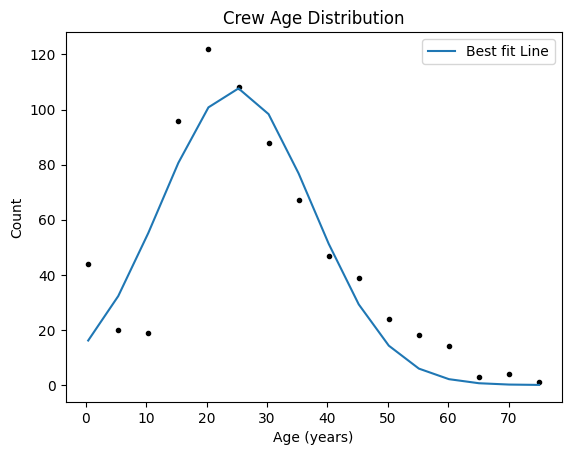

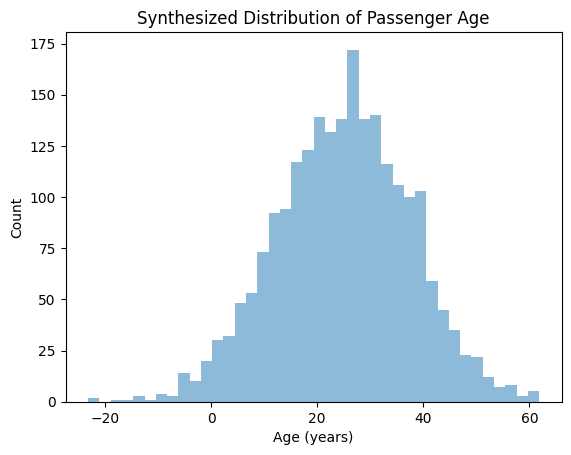

In [95]:
# Create histogram of ages
Age  = titanic['Age'][titanic['Age'].notna()]
binlist = []
for i in range(0, int(max(titanic['Age'])),53):
  binlist.append(i)

X= np.histogram(Age, bins = len(binlist))

# I will be fitting a double gaussian to the ages
def double_gaussian(x, c1, mu1, sigma1, c2, mu2, sigma2):
    res =   c1 * np.exp( - (x - mu1)**2.0 / (2.0 * sigma1**2.0) ) \
          + c2 * np.exp( - (x - mu2)**2.0 / (2.0 * sigma2**2.0) )
    return res
def Gauss(x,c,mu,sigma):
  return c * np.exp( - (x - mu)**2.0 / (2.0 * sigma**2.0) )

# def SynthAges(df, N, p0, output):

#   Age  = df['Age'][df['Age'].notna()]
#   binlist = []
#   for i in range(0, int(max(df['Age'])),3):
#     binlist.append(i)

#   X= np.histogram(Age, bins = len(binlist))

#   x = X[1][:len(X[0])]; y = X[0]

#   agedist = distr(x,y, double_gaussian, p0, output)

#   mu1 = agedist[0][1]
#   mu2 = agedist[0][4]
#   sd1 = agedist[0][2]
#   sd2 = agedist[0][5]

#   w1 = abs(agedist[0][0])/ (abs(agedist[0][0]) + agedist[0][3])
#   w2 = 1-w1

#   # print(w1, w2, w1+w2)

#   n_samples = N
#   # Correct counts
#   samples1 = np.random.normal(mu1, abs(sd1), int(n_samples * w1))
#   # samples1 = scipy.stats.t.rvs(4, loc=0, scale=1, size=n_samples, random_state=None)
#   samples2 = np.random.normal(mu2, abs(sd2), n_samples - len(samples1))

#   # Keep only in-range
#   samples1 = samples1[(samples1 > 0) & (samples1 < 80)]
#   samples2 = samples2[(samples2 > 0) & (samples2 < 80)]

#   # Top-up if clipping removed too many
#   while len(samples1) < int(n_samples * w1):
#     need  = int(n_samples * w1) - len(samples1)
#     extra = np.random.normal(mu1, abs(sd1), size=int(need*1.5))
#     keep = extra[(extra>0)&(extra<80)]
#     if keep.size == 0:
#       continue
#     samples1 = np.concatenate([samples1, keep])
#     samples1 = samples1[:int(n_samples * w1)]

#   print('Not Stuck')
#   while len(samples2) < int(n_samples - len(samples1)):
#     extra = np.random.normal(mu2, abs(sd2), size=10000)
#     samples2 = np.concatenate([samples2, extra[(extra>0)&(extra<80)]])
#     samples2 = samples2[:int(n_samples * (w2))]
#   print('Not Stuck')
#   return np.concatenate([samples1, samples2])

def SynthAges(df, N, p0, output):

  Age  = df['Age'][df['Age'].notna()]
  binlist = []
  for i in range(0, int(max(df['Age'])),5):
    binlist.append(i)

  X= np.histogram(Age, bins = len(binlist))

  x = X[1][:len(X[0])]; y = X[0]

  agedist = distr(x,y, Gauss, p0, output)

  c = agedist[0][0]
  mu = agedist[0][1]
  sd = agedist[0][2]

  n_samples = N
  # Correct counts
  samples1 = np.random.normal(mu, abs(sd), int(n_samples))


  return samples1

# p0 = [15, 25 , 10, 50, 35, 15]
p0_pass = [15, 0 , 10]
p0_crew = [15,25,10]
test = SynthAges(Pdf,2224, p0_pass, output= True)
plt.title('Crew Age Distribution')
plt.xlabel('Age (years)')
plt.ylabel('Count')


plt.figure()
# plt.hist(Age, bins = 20, alpha = 0.5, density = False);
plt.hist(test, bins = 40, alpha = 0.5,density = False);
plt.title('Synthesized Distribution of Passenger Age')
plt.xlabel('Age (years)')
plt.ylabel('Count')
print(len(test))

## Ticket Prices
Since the ticket prices follow an exponential trend, I will use the lognormal distribution to prescribe ticket prices to my synthetic data.

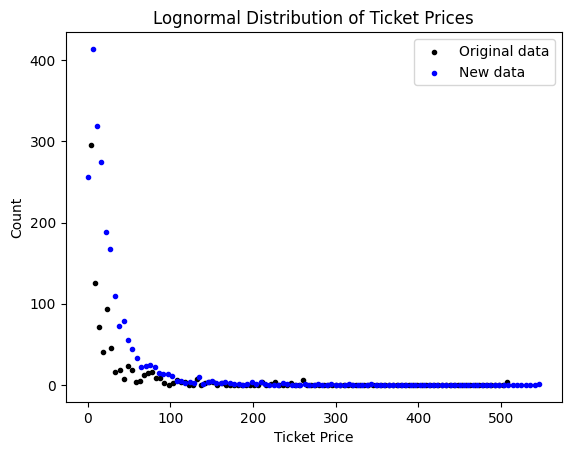

In [97]:
def SynthFare(df, farebin, n, output):

  # Get the ticket price column from the dataset
  Fare = titanic['Fare'][titanic['Fare'].notna()][titanic['Fare'] > 0]
  # Create histogram of ages from dataset
  binlist = []
  for i in range(0, int(max(titanic['Fare'])), farebin):
    binlist.append(i)

  X= np.histogram(Fare, bins = len(binlist))
  x = X[1][:len(X[0])]; y = X[0]

  # Generate samples
  log_fare_mean = np.log(df["Fare"][df["Fare"] > 0]).mean()
  log_fare_std  = np.log(df["Fare"][df["Fare"] > 0]).std()
  fares = np.random.lognormal(mean=log_fare_mean, sigma=log_fare_std, size=n)

  if output:
    plt.figure()
    plt.scatter(x,y, color = 'black', marker = '.', label = 'Original data')
    X = np.histogram(fares, bins = len(binlist))
    x = X[1][:len(X[0])]; y = X[0]

    plt.scatter(x,y,color = 'blue', marker = '.', label = 'New data')
    plt.legend(loc = 'best')
    plt.title('Lognormal Distribution of Ticket Prices')
    plt.xlabel('Ticket Price')
    plt.ylabel('Count')

  return fares

test = SynthFare(titanic, 5, 2224, output = True)



## Gender

There's not much of a distribution here, you either are a woman or a man. For time's sake, I will use the gender split seen in the dataset and assign genders based on those percentages.

# Putting it all together to generate a full synthetic dataset

In [14]:
def SynthData(df,
              N,
              Agep0,
              farebin,
              passenger,
              output):

  # synthesizing ages
  ages = SynthAges(df, N, Agep0, output)


  # Synthesizing genders
  sex_probs = df["Sex"].value_counts(normalize=True)
  sexes = np.random.choice(["male", "female"], size=N, p=sex_probs.values)


  if passenger:  # Passengers have more variables than crew
    # synthesizing ticket prices
    fares = SynthFare(df, farebin, N, output)
    # print(len(fares))

    # Synthesizing ticket class
    pclass_probs = df["Pclass"].value_counts(normalize=True).sort_index()
    pclasses = np.random.choice([1, 2, 3], size=N, p=pclass_probs.values)
    # print(len(pclasses))

    # Creating new dataframe
    Newdf = pd.DataFrame({
        "Sex": sexes ,
        "Age": ages,
        "Fare": fares,
        "Pclass": pclasses
        })

  else: # Crew has less variables than passengers
    # Creating new dataframe
    Newdf = pd.DataFrame({
        "Sex": sexes ,
        "Age": ages,
        })
  # print(len(ages))
  # print(len(sexes))

  return Newdf

# N = 2224 - len(titanic)
# p0_pass = [15, 0 , 10, 50, 21, 15]
# p0_crew = [15, 25 , 10, 50, 35, 15]
# synPass = SynthData(Pdf, N, p0_pass, 5, passenger = True, output = False)
# synPass["Sex"] = synPass["Sex"].map({"male": 0, "female": 1})

# synPass['p_survive'] = Psurvivability(titanic, 'Passenger', testsize = 1)[0].predict_proba(synPass)[:, 1]


# synCrew = SynthData(Cdf, N, p0_crew, 5, passenger = False, output = False)
# synCrew["Sex"] = synCrew["Sex"].map({"male": 0, "female": 1})

# synCrew['p_survive'] = Psurvivability(Cdf, 'Crew', testsize = 1)[0].predict_proba(synCrew)[:, 1]

In [15]:
import random

def liveordie(env, p_survive, rng, outcomes):
    """SimPy process: decide if this passenger survives."""
    yield env.timeout(0)                 # no real delay in this toy model
    survived = rng.random() < p_survive
    outcomes.append(survived)

def simulate_survival(prob_series, seed=1):
    """
    Run one replication.

    Parameters
    ----------
    prob_series : pandas.Series
        One survival probability per individual (index ≈ passenger‑id).
    seed : int, default 1
        RNG seed for reproducibility.

    Returns
    -------
    pandas.DataFrame with columns ['id', 'survived'].
    """
    env       = simpy.Environment()
    rng       = random.Random(seed)
    outcomes  = []                       # collect results here

    for pid, p in prob_series.items():

      env.process(liveordie(env, p, rng, outcomes))

    env.run()                            # advance until all processes finish
    return pd.DataFrame(outcomes, columns=['survived'])


# result = simulate_survival(synCrew['p_survive'], seed=42)
# survival_counts = result['survived'].value_counts()

# print("Empirical survival rate:", result['survived'].mean())
# print(survival_counts)

# Making a function that completes the entire procedure

In [29]:
import scipy.stats as stats

def GetN(mu, sigma, min_size, max_size):
  total = int(np.clip(np.random.normal(loc = mu, scale = sigma, size =1), min_size, max_size))
  passengers = int(total * 1317/(1317+885))
  crew = total - passengers
  return passengers, crew

def CI(x,avg):
  stdsurvrate = np.std(x)
  n = len(x)

  ci_low, ci_high = stats.t.interval(confidence = 0.95,
                                     df=n-1,
                                     loc=avg,
                                      scale= stdsurvrate / np.sqrt(n))
  return ci_low, ci_high

def Titanic_Simulations(Simulations,
                        mu,
                        sigma,
                        min_size,
                        max_size,
                        Pdf,
                        Cdf,
                        p0_pass,
                        p0_crew,
                        farebin
                        ):
  deaths = []
  survivors = []
  survivalrates = []
  people = []

  for i in range(Simulations):

    # Get number of passengers and crew
    passengers, crew = GetN(mu, sigma, min_size, max_size)
    people.append(passengers + crew)
    # print(passengers)
    # Synthesize passenger data and calculate survival probabilities

    synPass = SynthData(Pdf, passengers, p0_pass, farebin, passenger = True, output = False)
    synPass["Sex"] = synPass["Sex"].map({"male": 0, "female": 1})
    synPass['p_survive'] = Psurvivability(titanic, 'Passenger', testsize = 0.2)[0].predict_proba(synPass)[:, 1]

    # Synthesize crew data and calculate survival probabilities
    synCrew = SynthData(Cdf, crew, p0_crew, farebin, passenger = False, output = False)
    synCrew["Sex"] = synCrew["Sex"].map({"male": 0, "female": 1})
    synCrew['p_survive'] = Psurvivability(Cdf, 'Crew', testsize = 0.2)[0].predict_proba(synCrew)[:, 1]

    Psim = simulate_survival(synPass['p_survive'], seed=42)
    Csim = simulate_survival(synCrew['p_survive'], seed=42)

    deaths.append(Psim['survived'].value_counts()[0] + Csim['survived'].value_counts()[0])
    survivors.append(Psim['survived'].value_counts()[1] + Csim['survived'].value_counts()[1])
    survivalrates.append((Psim['survived'].value_counts()[1] + Csim['survived'].value_counts()[1])/(passengers + crew))

  avgpeople = np.average(people)
  avgdeaths = np.average(deaths)
  avgsurvivors = np.average(survivors)
  avgsurvivalrates = np.average(survivalrates)

  print(f'Average people:{avgpeople}')
  print(f'Average deaths:{avgdeaths}')
  print(f'Average survivors {avgsurvivors}')
  print(f'Average survival rate {avgsurvivalrates}')

  # Get confidence intervals
  ci_lowrate, ci_highrate = CI(survivalrates, avgsurvivalrates)
  ci_lowdeaths, ci_highdeaths = CI(deaths, avgdeaths)
  ci_lowsurvivors, ci_highsurvivors = CI(survivors, avgsurvivors)

  print(f"95% Confidence interval for survivors: ({ci_lowsurvivors:.3f}, {ci_highsurvivors:.3f})")
  print(f"95% Confidence interval for deaths: ({ci_lowdeaths:.3f}, {ci_highdeaths:.3f})")
  print(f"95% Confidence interval for survival rates: ({ci_lowrate:.3f}, {ci_highrate:.3f})")


  return deaths, survivors, survivalrates



In [30]:
## Loading titanic passenger dataset
Pfilename = "/content/drive/My Drive/Systems Engineering/titanic.csv"
Pdf = pd.read_csv(Pfilename)

## Loading and cleaning titanic crew dataset
Cfilename = "/content/drive/My Drive/Systems Engineering/titanic-tot.csv"
Cdf = pd.read_csv(Cfilename)
# Taking only the crew data
Cdf = Cdf[~Cdf['class'].str.contains(r'[123]', na=False)]
# Standardizing column names for the functions
Cdf.rename(columns={'gender': 'Sex', 'age':'Age', 'survived':'Survived'}, inplace=True)
# Changing indicator for yes and no
Cdf['Survived'] = Cdf["Survived"].map({"no": 0, "yes": 1})

# Initial guesses for gaussian fit for age distribution.
# Determined earlier via testing.
# p0_pass = [15, 0 , 10, 50, 21, 15]
# p0_crew = [15, 25 , 10, 50, 35, 15]
p0_pass = [15, 0 , 10]
p0_crew = [15, 25 , 10]
# Bin size for exponential fit
farebin = 5

run = Titanic_Simulations(Simulations = 10,
                          mu = 2224,
                          sigma = 400,
                          min_size= 1000,
                          max_size = 3338,
                          Pdf = Pdf,
                          Cdf = Cdf,
                          p0_pass = p0_pass,
                          p0_crew = p0_crew,
                          farebin = farebin)

Average people:2299.0
Average deaths:1509.2
Average survivors 789.8
Average survival rate 0.3439929085965089
95% Confidence interval for survivors: (677.290, 902.310)
95% Confidence interval for deaths: (1283.836, 1734.564)
95% Confidence interval for survival rates: (0.341, 0.347)


Run again but use the titanic-modified.csv data.

In [98]:
## Loading titanic passenger dataset
Pfilename = "/content/drive/My Drive/Systems Engineering/titanic-modified.csv"
Pdf = pd.read_csv(Pfilename)

p0_pass = [15, 0 , 10]
p0_crew = [15, 25 , 10]
# Bin size for exponential fit
farebin = 5

run = Titanic_Simulations(Simulations = 10,
                          mu = 2224,
                          sigma = 400,
                          min_size= 1000,
                          max_size = 3338,
                          Pdf = Pdf,
                          Cdf = Cdf,
                          p0_pass = p0_pass,
                          p0_crew = p0_crew,
                          farebin = farebin)

Average people:2199.2
Average deaths:1429.6
Average survivors 769.6
Average survival rate 0.3496917959271756
95% Confidence interval for survivors: (680.274, 858.926)
95% Confidence interval for deaths: (1271.966, 1587.234)
95% Confidence interval for survival rates: (0.347, 0.352)


# Comparing synthetic and real datasets

In [72]:
def compare(real, syn, passenger):
    out = {}
    out['n']           = (len(real), len(syn))
    out['mean_prob']   = (
        Psurvivability(real, passenger, testsize= 0.25)[1].mean(),
        Psurvivability(real, passenger, testsize = 0.25)[0].predict_proba(syn)[:,1].mean()
    )
    realgender = real['Sex'].map({'male': 0, 'female': 1})

    out['sex_ratio']   = (realgender.mean(), syn['Sex'].mean())          # 0=male,1=female
    out['age_mean']    = (real['Age'].mean(),   syn['Age'].mean())
    if passenger:
      out['pclass_mean'] = (real['Pclass'].mean(), syn['Pclass'].mean())
      out['fare_mean']   = (real['Fare'].mean(),  syn['Fare'].mean())
      out['fare_99%']    = (real['Fare'].quantile(.99), syn['Fare'].quantile(.99))

    return pd.Series(out)
N = 2224 - len(titanic)
p0_pass = [15, 0 , 10]
p0_crew = [15, 25 , 10]
synPass = SynthData(Pdf, N, p0_pass, 5, passenger = True, output = False)
synPass["Sex"] = synPass["Sex"].map({"male": 0, "female": 1})

synPass['p_survive'] = Psurvivability(titanic, 'Passenger', testsize = 1)[0].predict_proba(synPass)[:, 1]


synCrew = SynthData(Cdf, N, p0_crew, 5, passenger = False, output = False)
synCrew["Sex"] = synCrew["Sex"].map({"male": 0, "female": 1})

synCrew['p_survive'] = Psurvivability(Cdf, 'Crew', testsize = 1)[0].predict_proba(synCrew)[:, 1]
real_df = Cdf.drop(columns=['p_survive'], errors='ignore')
syn_df  = synCrew.drop(columns=['p_survive'], errors='ignore')

print(compare(real_df, syn_df, passenger = False))

n                                             (890, 1333)
mean_prob       (0.24336537089153046, 0.2511648474949795)
sex_ratio    (0.025842696629213482, 0.024756189047261814)
age_mean         (31.652808988764043, 27.541304287445747)
dtype: object
